In [ ]:
import pandas as pd
import numpy as np
import logging
from pathlib import Path
from tqdm import tqdm
from transformers import AutoModel, AutoTokenizer
import torch

In [ ]:
# --- 1. Configuración de Rutas y Constantes ---
ROOT = Path.cwd().parent
DATA_DIR_PROCESSED = ROOT / "data" / "02_processed"
DATA_DIR_FINAL = ROOT / "data" / "03_final"

MODEL_DIR = ROOT / "models" / "mi_modelo_stance_chileno"
STANCE_DIR = DATA_DIR_PROCESSED / "dialogue_master_clean.parquet"

In [ ]:
from setfit import SetFitModel

# 2. Carga el modelo SetFit
modelo_cargado = SetFitModel.from_pretrained(MODEL_DIR)

print("¡Modelo SetFit (con encoder y clasificación) cargado!")

¡Modelo SetFit (con encoder y clasificación) cargado!


/usr/local/lib/python3.12/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator LogisticRegression from version 1.7.2 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [ ]:
df_stance = pd.read_parquet(STANCE_DIR)
df_stance.head()

,nombre_dip,text,source_file,fecha_completa,fecha_datetime,speaker_type,sexo,numero_legislatura,numero_sesion,boletin_rescatado,...,postura_promedio,titulos_boletines,topics_boletines,boletin_inferido,titulo_final,topico_final,postura_titulo_final,promedio_stance_boletin,postura_promedio_boletin_cat,prediccion_id
0,Juan Bustos Ramírez,"El señor BUSTOS.- Señora Presidenta, la reform...",C:/Users/conjv/Desktop/boletines_json/legislat...,10-04-2002 10:36:00,2002-04-10,Diputado,male,346,10,2852-07,...,Neutral,Crea nuevas salas en las Cortes de Apelaciones...,13_monumento_autoriza_memoria_erigir,2852-07,Crea nuevas salas en las Cortes de Apelaciones...,13_monumento_autoriza_memoria_erigir,A Favor,0.983699,A Favor,0
1,José Miguel Ortiz Novoa,"El señor ORTIZ.- Señora Presidenta, el día de ...",C:/Users/conjv/Desktop/boletines_json/legislat...,10-04-2002 10:36:00,2002-04-10,Diputado,male,346,10,2852-07,...,Neutral,Crea nuevas salas en las Cortes de Apelaciones...,13_monumento_autoriza_memoria_erigir,2852-07,Crea nuevas salas en las Cortes de Apelaciones...,13_monumento_autoriza_memoria_erigir,Neutral,0.141427,Neutral,0
2,Edgardo Riveros Marín,"El señor RIVEROS.- Señora Presidenta, comparti...",C:/Users/conjv/Desktop/boletines_json/legislat...,10-04-2002 10:36:00,2002-04-10,Diputado,male,346,10,2852-07,...,A Favor,Crea nuevas salas en las Cortes de Apelaciones...,13_monumento_autoriza_memoria_erigir,2852-07,Crea nuevas salas en las Cortes de Apelaciones...,13_monumento_autoriza_memoria_erigir,A Favor,0.761392,A Favor,2
3,Guillermo Ceroni Fuentes,"El señor CERONI.- Señora Presidenta, no hay du...",C:/Users/conjv/Desktop/boletines_json/legislat...,10-04-2002 10:36:00,2002-04-10,Diputado,male,346,10,2852-07,...,A Favor,Crea nuevas salas en las Cortes de Apelaciones...,13_monumento_autoriza_memoria_erigir,2852-07,Crea nuevas salas en las Cortes de Apelaciones...,13_monumento_autoriza_memoria_erigir,A Favor,0.536003,A Favor,2
4,María Pía Guzmán Mena,La señora GUZMÁN (doña Pía).- Señora President...,C:/Users/conjv/Desktop/boletines_json/legislat...,10-04-2002 10:36:00,2002-04-10,Diputado,female,346,10,2852-07,...,A Favor,Crea nuevas salas en las Cortes de Apelaciones...,13_monumento_autoriza_memoria_erigir,2852-07,Crea nuevas salas en las Cortes de Apelaciones...,13_monumento_autoriza_memoria_erigir,A Favor,0.313146,A Favor,2


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [ ]:
df_stance.columns

Index(['nombre_dip', 'text', 'source_file', 'fecha_completa', 'fecha_datetime',
       'speaker_type', 'sexo', 'numero_legislatura', 'numero_sesion',
       'boletin_rescatado', 'supports_score', 'opposes_score', 'neutral_score',
       'stance_score', 'postura_discurso', 'promedio_hablante_dia',
       'postura_promedio', 'titulos_boletines', 'topics_boletines',
       'boletin_inferido', 'titulo_final', 'topico_final',
       'postura_titulo_final', 'promedio_stance_boletin',
       'postura_promedio_boletin_cat', 'prediccion_id'],
      dtype='object')

In [ ]:
df_stance['text_titulo'] = "Contexto: " + df_stance['titulo_final'].fillna("") + " " + df_stance['text'].fillna("")

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [ ]:
textos_a_clasificar = list(df_stance['text_titulo'])

batch_size = 32

batches = [textos_a_clasificar[i:i + batch_size] for i in range(0, len(textos_a_clasificar), batch_size)]

todas_las_predicciones = []

# Iterar sobre los lotes con tqdm
for batch in tqdm(batches, desc="Clasificando textos"):
    # El método predict dentro de SetFit está optimizado para lotes
    predicciones_batch = modelo_cargado.predict(batch)
    todas_las_predicciones.extend(predicciones_batch)

print(f"\nTotal de predicciones generadas con barra de progreso: {len(todas_las_predicciones)}")

Se truncaron las últimas líneas 5000 del resultado de transmisión.
Clasificando textos:  16%|█▌        | 482/2981 [01:45<09:23,  4.43it/s]/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
Clasificando textos:  16%|█▌        | 483/2981 [01:46<09:18,  4.48it/s]/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
Clasificando textos:  16%|█▌        | 484/2981 [01:46<09:11,  4.53it/s]/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: Depreca


Total de predicciones generadas con barra de progreso: 95371


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)



/usr/local/lib/python3.12/dist-packages/pandas/core/dtypes/cast.py:1601: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  result[:] = values
/tmp/ipython-input-4028523.py:19: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  plt.hist(predicciones_serie, bins=np.arange(predicciones_serie.min(), predicciones_serie.max() + 2) - 0.5, rwidth=0.8, color='#3498db')
/tmp/ipython-input-4028523.py:28: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  plt.xticks(np.arange(predicciones_serie.min(), predicciones_serie.max() + 1)) # Asegura que los ticks sean enteros


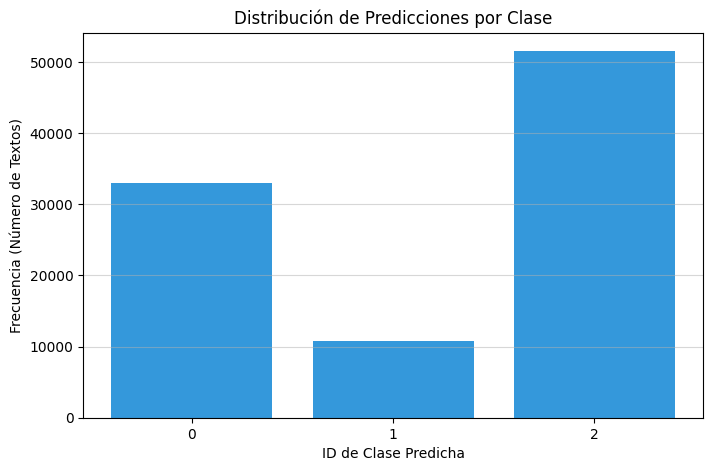

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Si tus etiquetas son, por ejemplo, 0, 1, 2
# Y sabes el mapeo:
# Etiqueta_mapa = {0: "Positivo", 1: "Neutro", 2: "Negativo"}
# Puedes usar un DataFrame para mayor claridad

# Convierte el array de predicciones a un DataFrame/Serie de Pandas
predicciones_serie = pd.Series(todas_las_predicciones)

# Opcional: Aplicar el mapeo de etiquetas (si lo tienes)
# predicciones_mapeadas = predicciones_serie.map(Etiqueta_mapa)

plt.figure(figsize=(8, 5))

# Generar el histograma
# Si usas predicciones_array (IDs numéricos)
plt.hist(predicciones_serie, bins=np.arange(predicciones_serie.min(), predicciones_serie.max() + 2) - 0.5, rwidth=0.8, color='#3498db')

# Si usas predicciones_mapeadas (nombres de etiquetas)
# sns.countplot(y=predicciones_mapeadas, order=predicciones_mapeadas.value_counts().index, color='#3498db')
# Nota: Si usas nombres de etiquetas, 'seaborn' con 'countplot' es mejor.

plt.title('Distribución de Predicciones por Clase')
plt.xlabel('ID de Clase Predicha')
plt.ylabel('Frecuencia (Número de Textos)')
plt.xticks(np.arange(predicciones_serie.min(), predicciones_serie.max() + 1)) # Asegura que los ticks sean enteros
plt.grid(axis='y', alpha=0.5)
plt.show()

In [ ]:
import pandas as pd

# 1. Asegúrate de que las longitudes coincidan
# Esto es una verificación de seguridad crucial
if len(todas_las_predicciones) == len(df_stance):

    # 2. Agrega la nueva columna al DataFrame
    # Las predicciones son los IDs numéricos de las clases (0, 1, 2, etc.)
    df_stance['prediccion_titulo_id'] = todas_las_predicciones

    print("✅ Columna 'prediccion_id' agregada exitosamente al DataFrame df_stance.")
    print(f"Total de filas en df_stance: {len(df_stance)}")

else:
    print(f"❌ Error: La longitud de las predicciones ({len(todas_las_predicciones)}) no coincide con el número de filas del DataFrame ({len(df_stance)}).")

# Mostrar las primeras filas para verificar
print("\nPrimeras 5 filas con la nueva columna:")
print(df_stance.head())

✅ Columna 'prediccion_id' agregada exitosamente al DataFrame df_stance.
Total de filas en df_stance: 95371

Primeras 5 filas con la nueva columna:
                 nombre_dip  \
0       Juan Bustos Ramírez   
1   José Miguel Ortiz Novoa   
2     Edgardo Riveros Marín   
3  Guillermo Ceroni Fuentes   
4     María Pía Guzmán Mena   

                                                text  \
0  El señor BUSTOS.- Señora Presidenta, la reform...   
1  El señor ORTIZ.- Señora Presidenta, el día de ...   
2  El señor RIVEROS.- Señora Presidenta, comparti...   
3  El señor CERONI.- Señora Presidenta, no hay du...   
4  La señora GUZMÁN (doña Pía).- Señora President...   

                                         source_file       fecha_completa  \
0  C:/Users/conjv/Desktop/boletines_json/legislat...  10-04-2002 10:36:00   
1  C:/Users/conjv/Desktop/boletines_json/legislat...  10-04-2002 10:36:00   
2  C:/Users/conjv/Desktop/boletines_json/legislat...  10-04-2002 10:36:00   
3  C:/Users/conjv/Des

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [ ]:
df_stance['prediccion_titulo_id'] = df_stance['prediccion_titulo_id'].apply(lambda x: x.item())

In [ ]:
df_stance.to_parquet(STANCE_DIR, index=False)